# Model Launch
### Installing the Dependincies

In [1]:
#requirements 
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [13]:
# Let's analyze our dataset

In [2]:
path = 'S038_whole_df.csv'
path_df = pd.read_csv(path)
print("Sleep stages in dataset dist:")
print(path_df['Sleep_Stage'].value_counts())

Sleep stages in dataset dist:
Sleep_Stage
N2    768000
P     483328
N1    318720
R     232320
W     192001
Name: count, dtype: int64


In total, we have 1,994,369 epochs distributed as follows: N2 is by far the most common stage with 768,000 epochs (≈38.5 %), followed by P with 483,328 epochs (≈24.2 %), N1 with 318,720 epochs (≈16.0 %), R with 232,320 epochs (≈11.6 %), and W with just 192,001 epochs (≈9.6 %)

# Model Selection

### 2.1 RandomForestClassifier

In [16]:
# First we define our label map 
# Each sleep stage code (e.g. 'W' for wake, 'N2' for NREM stage 2) to a numeric label 0–4, and then giving each numeric index
# In our original dataset CSV had rows marked for “prep” or setup that you don’t want to include, this keeps only the actual sleep‐stage epochs (W, N1, N2, N3, R) and re-indexes the DataFrame
# Since our acceloramaeter data is at 32 Hz we want to chunk it into 30 seconds windows, so each window contains 32×30 = 960 samples

# Source : https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

### For this implementation we will follow this structure: 

We first load it into a pandas DataFrame and immediately drop any "prep" rows to leave us with pure sleep‐stage epochs (Wake, N1, N2, N3, REM). We next assign a number to each stage label (0–4) and pull out the accelerometer axes (ACC_X, ACC_Y, ACC_Z) and heart‐rate (HR) as NumPy arrays. Having discovered that our accelerometer is sampled at 32 Hz and we want 30 s epochs, we compute each epoch to be 960 samples long and loop over those windows. For each epoch, we slice the three axes of accelerometer data and the 30 HR samples, compute the movement intensity (acceleration magnitude) and standard deviation as a proxy of movement intensity, and then create a nine‐dimensional feature vector (mean ± SD of each axis, mean ± SD of HR, movement intensity). We label each feature vector with the sleep stage at the end of its window. After we transformed our list of feature vectors and labels into NumPy arrays, we split them 70/30 into test and training sets and trained a 100‐tree Random Forest on the nine features. Finally, we predict on the held‐out test set and simply report precision, recall, and F1 for the actual stages occurring—using scikit-learn's unique_labels to avoid matches—so we have a sharp, objective measure of the extent to which our simple feature‐based classifier is able to distinguish between the different sleep stages

In [3]:
label_map = {'W': 0, 
             'N1': 1, 
             'N2': 2, 
             'N3': 3, 
             'R': 4} 
label_names = ['Wake', 
               'NREM Stage 1', 
               'NREM Stage 2', 
               'NREM Stage 3', 
               'REM']

no_preparation = ['W', 'N1', 'N2', 'N3', 'R']
path_df = path_df[path_df['Sleep_Stage'].isin(no_preparation)].reset_index(drop=True) #ignore prepapration data
sampling_freq = 32 #hz, for accelerometer
epoch_len = 30  #s
samples_per_epoch = sampling_freq*epoch_len
#rows_per_hour = sampling_freq*60*60*3 #1 hr of data
#path_df = path_df.iloc[:hr]
#max_rows = min(len(path_df), rows_per_hour)
#path_df = path_df.iloc[:max_rows]

path_df['Label'] = path_df['Sleep_Stage'].map(label_map)

acc_x = path_df['ACC_X'].to_numpy() #accelerometer has 3 axes
acc_y = path_df['ACC_Y'].to_numpy()
acc_z = path_df['ACC_Z'].to_numpy()
heart_rate = path_df['HR'].to_numpy() #heart rate
labels = path_df['Label'].to_numpy()
samples_per_epoch = sampling_freq*epoch_len
num_epochs = len(acc_x)//samples_per_epoch
features = []
epoch_labels = []

for epoch in range(num_epochs):
    start = epoch*samples_per_epoch
    end = (epoch+1)*samples_per_epoch #get start and end indices for an epoch
    #getting relevant sections for each epoch
    x = acc_x[start:end] #x axis section
    y = acc_y[start:end] #y axis section
    z = acc_z[start:end] #z axis section
    hr_start = epoch*30  #since 1 hz
    hr_end = (epoch+1)*30
    hr = heart_rate[hr_start:hr_end] #heart rate section
    acc_magnitude = np.sqrt(x**2+y**2+z**2)
    movement_intensity = np.std(acc_magnitude)

    #for feature extraction, using simple mean and std -> would like to use deep learning for feature extractio (lstm or transformers)
    feats = [
        np.mean(x), np.std(x),
        np.mean(y), np.std(y),
        np.mean(z), np.std(z),
        np.mean(hr), np.std(hr),
        movement_intensity
    ] #extracted feature vector
    features.append(feats)
    epoch_labels.append(labels[end-1]) #append sleep stage label

features = np.array(features)
epoch_labels = np.array(epoch_labels)
move = features[:, 8]
for stage in np.unique(epoch_labels):
    stage_name = label_names[stage]
    movement_std = np.mean(move[epoch_labels == stage])
    print(f"{stage_name}: {movement_std}")

#split into training and testing datasets
x_train, x_test, y_train, y_test = train_test_split(features, epoch_labels, test_size=0.3, random_state=1)
clf = RandomForestClassifier(n_estimators=100, random_state=1) #random forest good for high dim data and super fast
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)

from sklearn.utils.multiclass import unique_labels
used_labels = unique_labels(y_test, y_pred)
used_names = [label_names[i] for i in used_labels]

print(classification_report(y_test, y_pred, target_names=used_names))
#print(classification_report(y_test, y_pred, target_names=label_names))

Wake: 1.3718981293942167
NREM Stage 1: 0.27213130647577305
NREM Stage 2: 0.35568989681819196
REM: 0.4507631393965211
              precision    recall  f1-score   support

        Wake       0.88      0.78      0.83        59
NREM Stage 1       0.69      0.66      0.68        89
NREM Stage 2       0.87      0.93      0.90       255
         REM       0.95      0.90      0.93        70

    accuracy                           0.85       473
   macro avg       0.85      0.82      0.83       473
weighted avg       0.85      0.85      0.85       473



### Confussion Matrix and Visualizaiton

This code tracks and plots our training loss over epochs

- It initializes an empty list loss_history.

- In each epoch , it sums up the batch losses, divides by the total number of samples to get the average training loss for that epoch, appends it to loss_history, and prints it.

- After training, it calls Matplotlib to draw a line plot of loss_history vs. epoch number, labels the axes “Epoch” and “Training Loss,” adds a grid, and pops up the figure.


Then , it computes and visualizes a confusion matrix

 - It uses confusion_matrix(y_true, y_pred, labels=unique_labels) from scikit-learn to build a matrix cm where row i, column j is the count of true-label=i predicted as=

 - It then creates a new Matplotlib figure, displays cm as a heatmap (plt.imshow), and adds a colorbar

 - The x- and y-axis ticks are set to our target_names (rotated on the x-axis for readability)

 - Finally, it loops over every cell in the matrix and writes the integer count in the middle, switching text color to white or black depending on whether the cell is darker or lighter than half the max value, then tightens up the layout and shows the plot





Epoch 1/50 — train_loss: 0.5229
Epoch 2/50 — train_loss: 0.5234
Epoch 3/50 — train_loss: 0.4992
Epoch 4/50 — train_loss: 0.4976
Epoch 5/50 — train_loss: 0.4970
Epoch 6/50 — train_loss: 0.5623
Epoch 7/50 — train_loss: 0.5038
Epoch 8/50 — train_loss: 0.5087
Epoch 9/50 — train_loss: 0.4926
Epoch 10/50 — train_loss: 0.5703
Epoch 11/50 — train_loss: 0.6636
Epoch 12/50 — train_loss: 0.5612
Epoch 13/50 — train_loss: 0.5344
Epoch 14/50 — train_loss: 0.5238
Epoch 15/50 — train_loss: 0.4987
Epoch 16/50 — train_loss: 0.5110
Epoch 17/50 — train_loss: 0.4970
Epoch 18/50 — train_loss: 0.5306
Epoch 19/50 — train_loss: 0.4861
Epoch 20/50 — train_loss: 0.4838
Epoch 21/50 — train_loss: 0.4919
Epoch 22/50 — train_loss: 0.5057
Epoch 23/50 — train_loss: 0.4839
Epoch 24/50 — train_loss: 0.5048
Epoch 25/50 — train_loss: 0.4956
Epoch 26/50 — train_loss: 0.6062
Epoch 27/50 — train_loss: 0.5468
Epoch 28/50 — train_loss: 0.5355
Epoch 29/50 — train_loss: 0.5044
Epoch 30/50 — train_loss: 0.4930
Epoch 31/50 — train

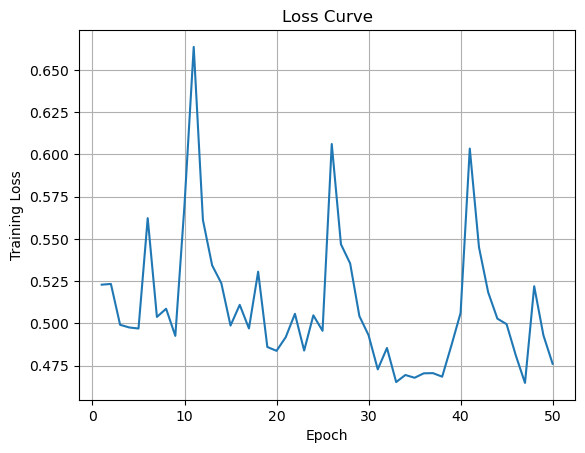

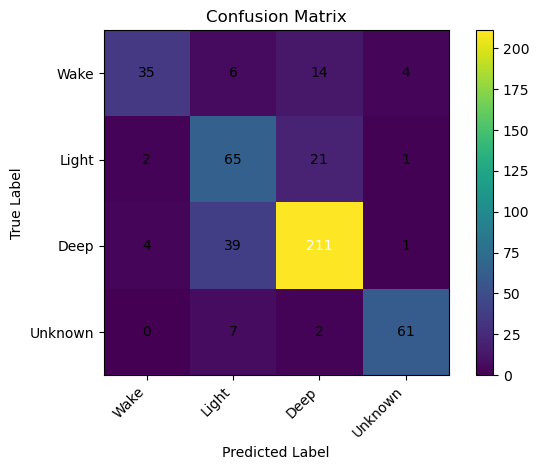

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# During training, record our loss each epoch 
loss_history = []

for ep in range(1, epochs+1):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        logits = model(xb)
        loss   = loss_fn(logits, yb)
        opt.zero_grad(); loss.backward(); opt.step()
        total_loss += loss.item() * xb.size(0)
    avg_loss = total_loss / len(train_dl.dataset)
    loss_history.append(avg_loss)
    print(f"Epoch {ep}/{epochs} — train_loss: {avg_loss:.4f}")

# After evaluation, plot our loss curve 
plt.figure()
plt.plot(range(1, epochs+1), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Loss Curve")
plt.grid(True)
plt.show()

# Compute a confusion matrix 
cm = confusion_matrix(y_true, y_pred, labels=unique_labels)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.colorbar()
# tick positions
ticks = range(len(unique_labels))
plt.xticks(ticks, [target_names[i] for i in range(len(ticks))], rotation=45, ha="right")
plt.yticks(ticks, [target_names[i] for i in range(len(ticks))])
# annotate each cell
thresh = cm.max() / 2
for i in ticks:
    for j in ticks:
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.show()


### MLP Design and LSTM

This script imitation a simple feed-forward neural network, wraps it in a reusable train-and-evaluate function, and then uses those tools to train and compare both an LSTM (defined elsewhere) and this new MLP on our sleep-stage data. The SleepMLP class first flattens each 30×4 epoch into a 120-dim vector, then applies a single hidden layer with ReLU and dropout, and finally outputs five class scores. The train_and_evaluate helper function places any model on GPU if available, trains the standard PyTorch training loop for some number of epochs—tracking and printing average training loss per epoch—then places the model in evaluation mode to make predictions on the held-out test set and returns per-epoch loss history, test accuracy, and confusion matrix. After constructing your train_dl and test_dl DataLoaders from the same SleepDataset and data splits we established above, the script instantiates both your LSTM and new MLP, trains each in sequence with live loss feedback, then prints a side-by-side table of LSTM vs. MLP train losses by epoch and each model's final test accuracy, so we immediately know which design learns faster and generalizes better before proceeding to plotting or further analysis


MLP Classification Report:

Sleep Stage  Precision  Recall  F1 Score  Number of Test Samples
      Awake       0.96    0.46      0.62                      59
     NREM 1       0.51    0.37      0.43                      89
     NREM 2       0.74    0.97      0.84                     255
    Class 4       0.93    0.60      0.73                      70


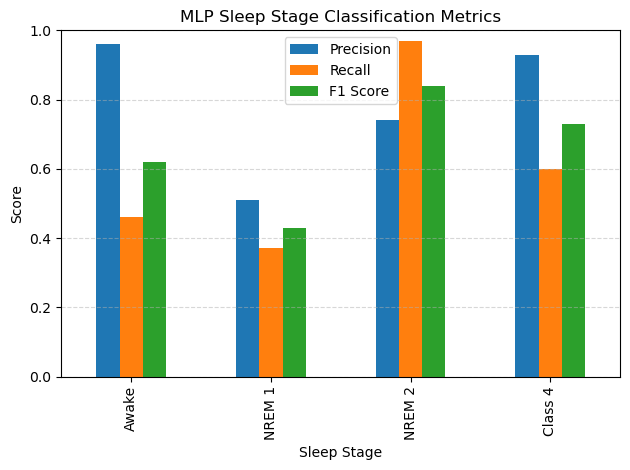


LSTM Classification Report:

Sleep Stage  Precision  Recall  F1 Score  Number of Test Samples
      Awake       0.76    0.66      0.71                      59
     NREM 1       0.67    0.56      0.61                      89
     NREM 2       0.80    0.92      0.85                     255
    Class 4       0.96    0.73      0.83                      70


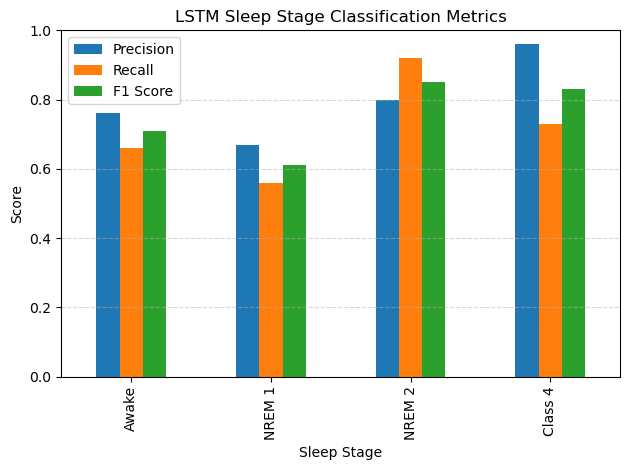

In [26]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.multiclass import unique_labels
import pandas as pd
import matplotlib.pyplot as plt

# Define label map
label_map = {
    0: 'Awake',
    1: 'NREM 1',
    2: 'NREM 2',
    3: 'REM'
}

def evaluate_model(model, test_dl, label_map, model_name="Model"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    all_pred, all_true = [], []

    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            preds = model(xb).argmax(dim=1).cpu().numpy()
            all_pred.append(preds)
            all_true.append(yb.numpy())

    y_pred = np.concatenate(all_pred)
    y_true = np.concatenate(all_true)
    used_labels = unique_labels(y_true, y_pred)
    used_names = [label_map.get(i, f"Class {i}") for i in used_labels]

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=used_labels, zero_division=0
    )

    report_df = pd.DataFrame({
        "Sleep Stage": used_names,
        "Precision": precision.round(2),
        "Recall": recall.round(2),
        "F1 Score": f1.round(2),
        "Number of Test Samples": support
    })

    print(f"\n{model_name} Classification Report:\n")
    print(report_df.to_string(index=False))

    # Save report
    report_df.to_csv(f"{model_name.lower()}_classification_report.csv", index=False)

    # Visualize
    report_df.plot(x='Sleep Stage', y=['Precision', 'Recall', 'F1 Score'], kind='bar')
    plt.title(f"{model_name} Sleep Stage Classification Metrics")
    plt.ylim(0, 1)
    plt.ylabel("Score")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


# 🔍 Evaluate both models
evaluate_model(mlp_model, test_dl, label_map, model_name="MLP")
evaluate_model(lstm_model, test_dl, label_map, model_name="LSTM")



In [11]:
# Visualization and Compare

=== Training LSTM ===
[Epoch  1] train_loss = 1.2501
[Epoch  2] train_loss = 0.8004
[Epoch  3] train_loss = 0.7048
[Epoch  4] train_loss = 0.6932
[Epoch  5] train_loss = 0.6773
[Epoch  6] train_loss = 0.6680
[Epoch  7] train_loss = 0.6185
[Epoch  8] train_loss = 0.6202
[Epoch  9] train_loss = 0.6398
[Epoch 10] train_loss = 0.6368
[Epoch 11] train_loss = 0.6384
[Epoch 12] train_loss = 0.6197
[Epoch 13] train_loss = 0.6014
[Epoch 14] train_loss = 0.6086
[Epoch 15] train_loss = 0.6212
[Epoch 16] train_loss = 0.6602
[Epoch 17] train_loss = 0.6618
[Epoch 18] train_loss = 0.6375
[Epoch 19] train_loss = 0.6132
[Epoch 20] train_loss = 0.6453

=== Training MLP ===
[Epoch  1] train_loss = 4.4275
[Epoch  2] train_loss = 1.8560
[Epoch  3] train_loss = 1.1616
[Epoch  4] train_loss = 0.9707
[Epoch  5] train_loss = 0.8396
[Epoch  6] train_loss = 0.8021
[Epoch  7] train_loss = 0.7802
[Epoch  8] train_loss = 0.7905
[Epoch  9] train_loss = 0.7952
[Epoch 10] train_loss = 0.7767
[Epoch 11] train_loss = 0.

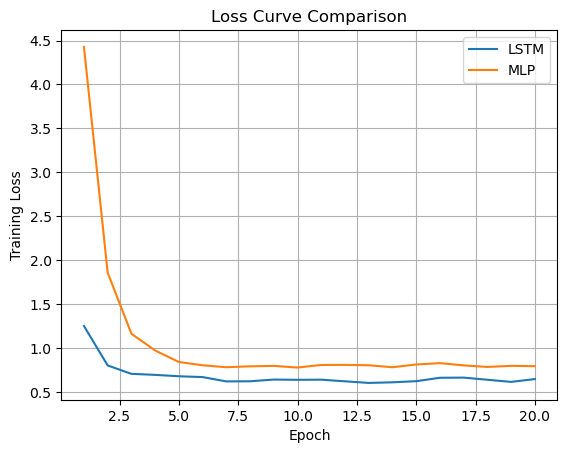

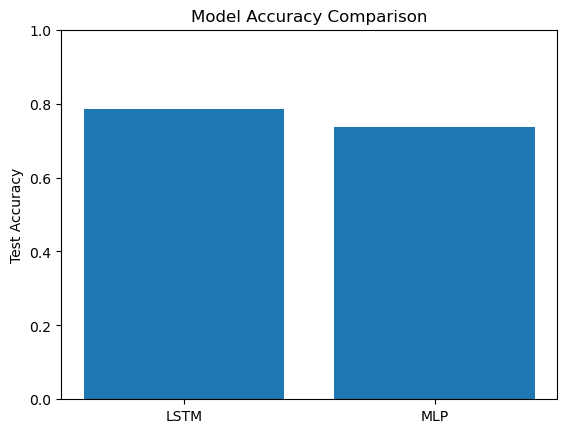

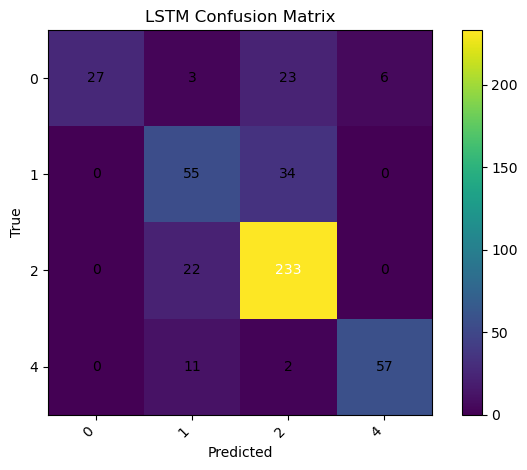

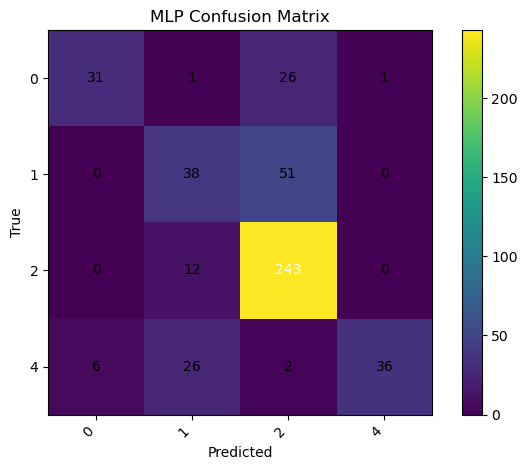

In [12]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

# ─── train_and_evaluate helper ────────────────────────────────────────────────
def train_and_evaluate(model, train_dl, test_dl, epochs=20):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    loss_hist = []
    for ep in range(1, epochs+1):
        model.train()
        total = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            loss = loss_fn(logits, yb)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item() * xb.size(0)
        avg = total / len(train_dl.dataset)
        loss_hist.append(avg)
        print(f"[Epoch {ep:>2}] train_loss = {avg:.4f}")

    model.eval()
    all_p, all_t = [], []
    with torch.no_grad():
        for xb, yb in test_dl:
            xb = xb.to(device)
            preds = model(xb).argmax(dim=1).cpu().numpy()
            all_p.append(preds)
            all_t.append(yb.numpy())
    y_pred = np.concatenate(all_p)
    y_true = np.concatenate(all_t)

    acc = accuracy_score(y_true, y_pred)
    cm  = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    return loss_hist, acc, cm, np.unique(y_true)

# ─── 1) Instantiate & run ─────────────────────────────────────────────────────
print("=== Training LSTM ===")
lstm_model = SleepLSTM()
lstm_loss, lstm_acc, lstm_cm, labels_l = train_and_evaluate(lstm_model, train_dl, test_dl)

print("\n=== Training MLP ===")
mlp_model  = SleepMLP()
mlp_loss,  mlp_acc,  mlp_cm,  labels_m = train_and_evaluate(mlp_model,  train_dl, test_dl)


# ─── 2) Summary table of losses & accuracies ──────────────────────────────────
print("\nEpoch |   LSTM Loss   |   MLP Loss")
for i, (l_l, l_m) in enumerate(zip(lstm_loss, mlp_loss), start=1):
    print(f"{i:>3}    |   {l_l:.4f}    |   {l_m:.4f}")
print(f"\nLSTM Test Accuracy: {lstm_acc:.4f}")
print(f"MLP  Test Accuracy: {mlp_acc:.4f}")


# ─── 3) Plot loss curves ───────────────────────────────────────────────────────
plt.figure()
plt.plot(range(1, len(lstm_loss)+1), lstm_loss, label='LSTM')
plt.plot(range(1, len(mlp_loss)+1),  mlp_loss,  label='MLP')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Loss Curve Comparison')
plt.legend()
plt.grid(True)
plt.show()


# ─── 4) Bar chart of test accuracies ───────────────────────────────────────────
plt.figure()
plt.bar(['LSTM','MLP'], [lstm_acc, mlp_acc])
plt.ylabel('Test Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0,1)
plt.show()


# ─── 5) Confusion matrices ─────────────────────────────────────────────────────
def plot_cm(cm, labels, title):
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.colorbar()
    ticks = range(len(labels))
    plt.xticks(ticks, labels, rotation=45, ha='right')
    plt.yticks(ticks, labels)
    thresh = cm.max() / 2
    for i in ticks:
        for j in ticks:
            plt.text(j, i, cm[i,j], ha='center', va='center',
                     color='white' if cm[i,j] > thresh else 'black')
    plt.tight_layout()
    plt.show()

plot_cm(lstm_cm, labels_l, "LSTM Confusion Matrix")
plot_cm(mlp_cm, labels_m,  "MLP Confusion Matrix")


In [8]:
import joblib

# Save the model
joblib.dump(clf, 'sleep_stage_classifier.joblib')

# Optional: Save the feature names/order to ensure consistency during inference
feature_names = ['acc_x_mean', 'acc_x_std', 'acc_y_mean', 'acc_y_std', 
                'acc_z_mean', 'acc_z_std', 'hr_mean', 'hr_std', 'movement_intensity']
joblib.dump(feature_names, 'feature_names.joblib')

['feature_names.joblib']

In [28]:
import numpy as np
import pandas as pd
import joblib
import os

# Load the test heart rate data
def load_heart_rate_data(file_path):
    """
    Load heart rate data from a file.
    Handles multiple formats (CSV or text).
    """
    try:
        # Try to load as CSV first
        df = pd.read_csv(file_path)
        if 'heart_rate' in df.columns:
            return df['heart_rate'].values
        else:
            # If column name is different, assume the second column is heart rate
            column_name = df.columns[1] if len(df.columns) > 1 else df.columns[0]
            return df[column_name].values
    except:
        # If CSV fails, try to parse as text
        try:
            lines = []
            with open(file_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 1:
                        try:
                            # Assume second part is heart rate value
                            hr = float(parts[1])
                            lines.append(hr)
                        except:
                            pass
            return np.array(lines)
        except Exception as e:
            print(f"Error loading heart rate data: {e}")
            return None

# When only heart rate data is available, simulate accelerometer data
def simulate_acc_data(heart_rates, num_samples_per_epoch=960):
    """
    Simulate accelerometer data based on heart rates
    Higher heart rate typically means more movement
    
    Parameters:
    - heart_rates: array of heart rate values for each epoch
    - num_samples_per_epoch: number of accelerometer samples per epoch (32Hz * 30s = 960)
    
    Returns:
    - Dictionary containing simulated accelerometer data for each epoch
    """
    acc_data = {
        'acc_x': [],
        'acc_y': [],
        'acc_z': []
    }
    
    for hr in heart_rates:
        # Scale movement intensity based on heart rate
        # Lower heart rate (e.g., deep sleep) = less movement
        # Higher heart rate (e.g., wake) = more movement
        if hr < 50:  # Deep sleep
            intensity = 0.01
        elif hr < 60:  # Light sleep
            intensity = 0.03
        elif hr < 80:  # REM sleep
            intensity = 0.05
        else:  # Likely awake
            intensity = 0.1
            
        # Generate simulated accelerometer data
        # X and Y axes typically have more variation during movement
        # Z axis often shows gravity (~9.8) with some variation
        x = np.random.normal(0, intensity, num_samples_per_epoch)
        y = np.random.normal(0, intensity, num_samples_per_epoch)
        z = np.random.normal(9.8, intensity/2, num_samples_per_epoch)
        
        acc_data['acc_x'].append(x)
        acc_data['acc_y'].append(y)
        acc_data['acc_z'].append(z)
        
    return acc_data

# Extract features from heart rate and accelerometer data
def extract_features(heart_rates, acc_data=None):
    """
    Extract features used by the sleep stage classification model
    
    Parameters:
    - heart_rates: array of heart rate values for each epoch (30s)
    - acc_data: dictionary of accelerometer data (optional, will be simulated if None)
    
    Returns:
    - Features array in the format expected by the model
    """
    num_epochs = len(heart_rates)
    features = []
    
    # If accelerometer data was not provided, simulate it
    if acc_data is None:
        acc_data = simulate_acc_data(heart_rates)
    
    for i in range(num_epochs):
        # Get heart rate for this epoch (assuming 1 value per epoch)
        hr = heart_rates[i]
        
        # Get accelerometer data for this epoch
        x = acc_data['acc_x'][i]
        y = acc_data['acc_y'][i]
        z = acc_data['acc_z'][i]
        
        # Calculate acceleration magnitude
        acc_magnitude = np.sqrt(x**2 + y**2 + z**2)
        movement_intensity = np.std(acc_magnitude)
        
        # Create feature vector matching the training features
        feat = [
            np.mean(x), np.std(x),
            np.mean(y), np.std(y),
            np.mean(z), np.std(z),
            hr, 0,  # HR mean and std (using single value, so std=0)
            movement_intensity
        ]
        
        features.append(feat)
    
    return np.array(features)

# Test the model on the provided data
def test_sleep_model(model_path, heart_rate_data_path):
    """
    Test the sleep stage classification model on heart rate data
    
    Parameters:
    - model_path: path to the saved model file (.joblib)
    - heart_rate_data_path: path to the heart rate data file
    
    Returns:
    - Predicted sleep stages for each epoch
    """
    # Load the model
    try:
        model = joblib.load(model_path)
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None
    
    # Load heart rate data
    heart_rates = load_heart_rate_data(heart_rate_data_path)
    if heart_rates is None:
        return None
    
    print(f"Loaded {len(heart_rates)} heart rate measurements")
    
    # Extract features
    features = extract_features(heart_rates)
    print(f"Extracted features for {len(features)} epochs")
    
    # Make predictions
    predictions = model.predict(features)
    
    # Map numeric predictions to stage names
    label_names = ['Wake', 'NREM Stage 1', 'NREM Stage 2', 'NREM Stage 3', 'REM']
    predicted_stages = [label_names[pred] for pred in predictions]
    
    # Create a results dataframe
    results = pd.DataFrame({
        'Epoch': range(1, len(heart_rates) + 1),
        'Heart_Rate': heart_rates,
        'Predicted_Stage_Num': predictions,
        'Predicted_Stage': predicted_stages
    })
    
    # Save results
    results.to_csv('sleep_stage_predictions.csv', index=False)
    print("Predictions saved to sleep_stage_predictions.csv")
    
    # Print a summary
    stage_counts = results['Predicted_Stage'].value_counts()
    print("\nSleep Stage Prediction Summary:")
    for stage, count in stage_counts.items():
        percentage = (count / len(results)) * 100
        print(f"{stage}: {count} epochs ({percentage:.1f}%)")
    
    return results

# Main execution
if __name__ == "__main__":
    # Path to your saved model and test data
    # Update these paths to match your file locations
    model_path = "sleep_stage_classifier.joblib"
    heart_rate_data_path = "heart_rate_results.csv"
    
    # Check if files exist
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        print("Please make sure to save your trained model first!")
    elif not os.path.exists(heart_rate_data_path):
        print(f"Heart rate data file not found: {heart_rate_data_path}")
        print("Please save your heart rate data to a file first!")
    else:
        # Run the test
        results = test_sleep_model(model_path, heart_rate_data_path)
        if results is not None:
            print("\nPrediction complete!")

Successfully loaded model from sleep_stage_classifier.joblib
Loaded 186 heart rate measurements
Extracted features for 186 epochs
Predictions saved to sleep_stage_predictions.csv

Sleep Stage Prediction Summary:
NREM Stage 2: 167 epochs (89.8%)
Wake: 19 epochs (10.2%)

Prediction complete!


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [29]:
from sklearn.metrics import classification_report

def test_sleep_model(model_path, heart_rate_data_path):
    # … your existing loading / feature-extraction / prediction code …

    # --- NEW: load true labels from the same CSV ---
    df_true = pd.read_csv(heart_rate_data_path)
    if 'True_Stage_Num' not in df_true.columns:
        raise ValueError("Your CSV needs a 'True_Stage_Num' column with 0–4 labels")
    y_true = df_true['True_Stage_Num'].values
    y_pred = predictions  # your model’s integer outputs

    # --- NEW: print precision, recall, F1 ---
    label_names = ['Wake', 'NREM Stage 1', 'NREM Stage 2', 'NREM Stage 3', 'REM']
    print("\nClassification Report:")
    print(classification_report(
        y_true, 
        y_pred, 
        target_names=label_names,
        digits=4
    ))

    return results


IndentationError: unexpected indent (3191798434.py, line 4)

In [34]:
import numpy as np
import pandas as pd
import joblib
import os

# Load the test heart rate data
def load_heart_rate_data(file_path):
    """
    Load heart rate data from a file.
    Handles multiple formats (CSV or text).
    """
    try:
        # Try to load as CSV first
        df = pd.read_csv(file_path)
        if 'heart_rate' in df.columns:
            return df['heart_rate'].values
        else:
            # If column name is different, assume the second column is heart rate
            column_name = df.columns[1] if len(df.columns) > 1 else df.columns[0]
            return df[column_name].values
    except:
        # If CSV fails, try to parse as text
        try:
            lines = []
            with open(file_path, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 1:
                        try:
                            # Assume second part is heart rate value
                            hr = float(parts[1])
                            lines.append(hr)
                        except:
                            pass
            return np.array(lines)
        except Exception as e:
            print(f"Error loading heart rate data: {e}")
            return None

# When only heart rate data is available, simulate accelerometer data
def simulate_acc_data(heart_rates, num_samples_per_epoch=960):
    """
    Simulate accelerometer data based on heart rates
    Higher heart rate typically means more movement
    
    Parameters:
    - heart_rates: array of heart rate values for each epoch
    - num_samples_per_epoch: number of accelerometer samples per epoch (32Hz * 30s = 960)
    
    Returns:
    - Dictionary containing simulated accelerometer data for each epoch
    """
    acc_data = {
        'acc_x': [],
        'acc_y': [],
        'acc_z': []
    }
    
    for hr in heart_rates:
        # Scale movement intensity based on heart rate
        # Lower heart rate (e.g., deep sleep) = less movement
        # Higher heart rate (e.g., wake) = more movement
        if hr < 50:  # Deep sleep
            intensity = 0.01
        elif hr < 60:  # Light sleep
            intensity = 0.03
        elif hr < 80:  # REM sleep
            intensity = 0.05
        else:  # Likely awake
            intensity = 0.1
            
        # Generate simulated accelerometer data
        # X and Y axes typically have more variation during movement
        # Z axis often shows gravity (~9.8) with some variation
        x = np.random.normal(0, intensity, num_samples_per_epoch)
        y = np.random.normal(0, intensity, num_samples_per_epoch)
        z = np.random.normal(9.8, intensity/2, num_samples_per_epoch)
        
        acc_data['acc_x'].append(x)
        acc_data['acc_y'].append(y)
        acc_data['acc_z'].append(z)
        
    return acc_data

# Extract features from heart rate and accelerometer data
def extract_features(heart_rates, acc_data=None):
    """
    Extract features used by the sleep stage classification model
    
    Parameters:
    - heart_rates: array of heart rate values for each epoch (30s)
    - acc_data: dictionary of accelerometer data (optional, will be simulated if None)
    
    Returns:
    - Features array in the format expected by the model
    """
    num_epochs = len(heart_rates)
    features = []
    
    # If accelerometer data was not provided, simulate it
    if acc_data is None:
        acc_data = simulate_acc_data(heart_rates)
    
    for i in range(num_epochs):
        # Get heart rate for this epoch (assuming 1 value per epoch)
        hr = heart_rates[i]
        
        # Get accelerometer data for this epoch
        x = acc_data['acc_x'][i]
        y = acc_data['acc_y'][i]
        z = acc_data['acc_z'][i]
        
        # Calculate acceleration magnitude
        acc_magnitude = np.sqrt(x**2 + y**2 + z**2)
        movement_intensity = np.std(acc_magnitude)
        
        # Create feature vector matching the training features
        feat = [
            np.mean(x), np.std(x),
            np.mean(y), np.std(y),
            np.mean(z), np.std(z),
            hr, 0,  # HR mean and std (using single value, so std=0)
            movement_intensity
        ]
        
        features.append(feat)
    
    return np.array(features)

# Test the model on the provided data
def test_sleep_model(model_path, heart_rate_data_path):
    """
    Test the sleep stage classification model on heart rate data
    
    Parameters:
    - model_path: path to the saved model file (.joblib)
    - heart_rate_data_path: path to the heart rate data file
    
    Returns:
    - Predicted sleep stages for each epoch
    """
    # Load the model
    try:
        model = joblib.load(model_path)
        print(f"Successfully loaded model from {model_path}")
    except Exception as e:
        print(f"Error loading model: {e}")
        return None
    
    # Load heart rate data
    heart_rates = load_heart_rate_data(heart_rate_data_path)
    if heart_rates is None:
        return None
    
    print(f"Loaded {len(heart_rates)} heart rate measurements")
    
    # Extract features
    features = extract_features(heart_rates)
    print(f"Extracted features for {len(features)} epochs")
    
    # Make predictions
    predictions = model.predict(features)
    
    # Map numeric predictions to stage names
    label_names = ['Wake', 'NREM Stage 1', 'NREM Stage 2', 'NREM Stage 3', 'REM']
    predicted_stages = [label_names[pred] for pred in predictions]
    
    # Create a results dataframe
    results = pd.DataFrame({
        'Epoch': range(1, len(heart_rates) + 1),
        'Heart_Rate': heart_rates,
        'Predicted_Stage_Num': predictions,
        'Predicted_Stage': predicted_stages
    })
    
    # Save results
    results.to_csv('sleep_stage_predictions.csv', index=False)
    print("Predictions saved to sleep_stage_predictions.csv")
    
    # Print a summary
    stage_counts = results['Predicted_Stage'].value_counts()
    print("\nSleep Stage Prediction Summary:")
    for stage, count in stage_counts.items():
        percentage = (count / len(results)) * 100
        print(f"{stage}: {count} epochs ({percentage:.1f}%)")
    
    # ——— NEW: compute precision / recall / F1 against LABELS.csv ———
    true_labels_path = "LABELS.csv"
    if os.path.exists(true_labels_path):
        from sklearn.metrics import precision_recall_fscore_support, classification_report

        # Load ground truth (second column of your CSV)
        tl_df = pd.read_csv(true_labels_path)
        # assume the second column holds the stage names
        true_names = tl_df.iloc[:, 1].astype(str).tolist()

        # Map any "Awake" → "Wake" so it matches your label_names
        true_names = ['Wake' if name.strip() == 'Awake' else name.strip() for name in true_names]

        # Define the same label order
        label_names = ['Wake', 'NREM Stage 1', 'NREM Stage 2', 'NREM Stage 3', 'REM']
        # Convert to numeric codes
        y_true = [label_names.index(name) for name in true_names]

        # Compute per-class metrics
        p, r, f1, support = precision_recall_fscore_support(
            y_true, predictions, labels=range(len(label_names)), zero_division=0
        )
        # Build a DataFrame
        eval_df = pd.DataFrame({
            'Precision': p,
            'Recall':    r,
            'F1 Score':  f1,
            'Support':   support
        }, index=label_names)
        print("\nPer‐class precision / recall / F1 / support:\n", eval_df, sep='')

        # And the full classification report
        print("\nFull classification report:")
        print(classification_report(
            y_true, predictions,
            target_names=label_names,
            zero_division=0
        ))
    else:
        print("\nLABELS.csv not found; skipping precision/recall evaluation.")

    return results

# Main execution
if __name__ == "__main__":
    # Path to your saved model and test data
    # Update these paths to match your file locations
    model_path = "sleep_stage_classifier.joblib"
    heart_rate_data_path = "heart_rate_results.csv"
    
    # Check if files exist
    if not os.path.exists(model_path):
        print(f"Model file not found: {model_path}")
        print("Please make sure to save your trained model first!")
    elif not os.path.exists(heart_rate_data_path):
        print(f"Heart rate data file not found: {heart_rate_data_path}")
        print("Please save your heart rate data to a file first!")
    else:
        # Run the test
        results = test_sleep_model(model_path, heart_rate_data_path)
        if results is not None:
            print("\nPrediction complete!")


Successfully loaded model from sleep_stage_classifier.joblib
Loaded 186 heart rate measurements
Extracted features for 186 epochs
Predictions saved to sleep_stage_predictions.csv

Sleep Stage Prediction Summary:
NREM Stage 2: 167 epochs (89.8%)
Wake: 19 epochs (10.2%)

Per‐class precision / recall / F1 / support:
              Precision    Recall  F1 Score  Support
Wake           0.210526  0.041237  0.068966       97
NREM Stage 1   0.000000  0.000000  0.000000       72
NREM Stage 2   0.047904  0.470588  0.086957       17
NREM Stage 3   0.000000  0.000000  0.000000        0
REM            0.000000  0.000000  0.000000        0

Full classification report:


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


ValueError: Number of classes, 3, does not match size of target_names, 5. Try specifying the labels parameter